### В данном Jupyter Notebook проводится обработка и об

Пайплайн:

1. Скачивание данных HERG-central;
2. Стандартизация единиц измерения активности к herg каналам, удаление дубликатов;
3. Кластеризация соединений с помощью python-скрипта от PatWalter: https://github.com/PatWalters/kmeans Параметры: fp = morgan3, dim = 2048, clusters = 500;
4. Анализ разбиения выборки на кластеры;
5. Составление наиболее сбалансированного валидацинного датасета из соединений разных кластеров;
6. Сохранение подготовленных данных в .csv файлы.

# Обработка данных с HERG-central

In [2]:
import logging
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean, std, zeros
from pandas import DataFrame
import pandas as pd
from pathlib import Path
import sys
from rdkit import Chem, DataStructs, RDConfig
from rdkit.Chem import AllChem, Descriptors, Draw, PandasTools, MolStandardize, DataStructs, ChemicalFeatures
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
from IPython.display import display, display_png
import rdkit.rdBase as rkrb
import rdkit.RDLogger as rkl
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
from rdkit.Chem.Pharm2D import Generate
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegressionCV, LinearRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.datasets import make_classification 
from tqdm import tqdm
import xgboost
from xgboost import XGBRFClassifier
#import time
from collections import Counter, defaultdict

C:\Users\elly-\Anaconda3\envs\my-edkit-env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
#! pip install tqdm

Загрузим датасет

In [4]:
df = pd.read_csv('herg_central.txt', delimiter = "\t")

In [5]:
df.isna().sum()

SMILES                         0
PubChem Substance ID           0
hERG inhibition (%) at 1uM     0
hERG inhibition (%) at 10uM    0
dtype: int64

Пропущенные значения отсутствуют

In [6]:
len(df)

306895

In [7]:
df = df.drop_duplicates(subset ="PubChem Substance ID")
df

,SMILES,PubChem Substance ID,hERG inhibition (%) at 1uM,hERG inhibition (%) at 10uM
0,C1=CC2=NC3=C(C=C(C(=NC(=O)C4=CC=CO4)N3CC5=CC=C...,22403712,-10.1124,-32.88202
1,C1C(CN(C1C(=O)OCC(=O)C2=CC=CC=C2Cl)S(=O)(=O)C3...,22411435,5.5191,4.12648
2,C1COCCN1C(=O)OC2=CC3=C(C=C2)C(=O)/C(=C/C4=CC=C...,17513249,9.5532,5.23978
3,CC1=NC2=CC=CC=C2C(=C1)C(=O)N/N=C/C3=CC(=CC=C3)...,17512209,-0.2112,-5.44332
4,COCCNC(=O)C1=C(N(C2=NC3=CC=CC=C3N=C12)CC4=CC=C...,14729741,12.6230,14.73378
...,...,...,...,...
306890,C1CCN(C1)S(=O)(=O)C2=CC=C(C=C2)C(=O)OCC(=O)NC3...,57262925,4.8576,1.38128
306891,C1CN(CCN1CC(=O)NC2=CC=C(C=C2)C(=O)N)S(=O)(=O)C...,57264745,4.4922,-3.78132
306892,CC1=CC(=C(C(=C1C)S(=O)(=O)N2CCN(CC2)C(=O)CNC(=...,57259638,-0.9701,-13.56112
306893,C1COCCN1C2=C(C=C(C=C2)C(F)(F)F)NC(=O)COC(=O)C3...,57261004,-7.1374,-25.02142


Дубликатов в данном наборе не оказалось

Удалим агонисты (соединения с отрицательной активностью и нулевой)

In [8]:
df = df[df['hERG inhibition (%) at 10uM'] > 0]

In [9]:
df

,SMILES,PubChem Substance ID,hERG inhibition (%) at 1uM,hERG inhibition (%) at 10uM
1,C1C(CN(C1C(=O)OCC(=O)C2=CC=CC=C2Cl)S(=O)(=O)C3...,22411435,5.5191,4.12648
2,C1COCCN1C(=O)OC2=CC3=C(C=C2)C(=O)/C(=C/C4=CC=C...,17513249,9.5532,5.23978
4,COCCNC(=O)C1=C(N(C2=NC3=CC=CC=C3N=C12)CC4=CC=C...,14729741,12.6230,14.73378
5,CC1CC(NC(=S)N1CC(=O)NCC2=CC=CC=C2Cl)(C)C,17511100,13.9004,13.68218
6,COC1=C(C=C(C=C1)C(=O)NC(=S)NC2=CC=C(C=C2)N3CCC...,17508525,11.3456,12.12248
...,...,...,...,...
306884,C1CCC(C1)NC(=O)CN2C(=O)C(NC2=O)(C3=CC=CC=C3)C4...,57260907,11.2146,4.94638
306885,CC1=CC(=C(C=C1)C)C(=O)CN2C(=O)C(=O)N(C2=O)C3CCCC3,57261825,6.1096,1.63218
306888,CC1=C(C=C(C=C1)OCC(=O)OCC(=O)NC2CC2)C,57262798,2.9471,4.09278
306890,C1CCN(C1)S(=O)(=O)C2=CC=C(C=C2)C(=O)OCC(=O)NC3...,57262925,4.8576,1.38128


Агонисты и антагонисты были представлены приблизительно половиной соединений

Удалим соли

In [10]:
df = df.drop(df[df.SMILES.str.contains(r'[.]')].index)
len(df)

162007

In [11]:
k = 0
l = 0
index_nan = []
for i in df["SMILES"]:
    k += 1
    if i == "":
        index_nan.append(df_all.index[k-1])
        l += 1
print(f"Number of str-nan:{l}")
print(f"Index of nan:{index_nan}")

Number of str-nan:0
Index of nan:[]


Проставим класс активности на основе значения % ингибирования при концентрации 10 мкМ

In [12]:
def count_class(df):
    activity_class =[]
    count = 0
    for index, row in df.iterrows():
        value = float(row["hERG inhibition (%) at 10uM"])
        if value > 50:
             activity_class.append(1)
        elif value == 50:
             activity_class.append(1)
        else:
            activity_class.append(0)
    df['class'] = activity_class
    return df

In [13]:
df = count_class(df)

In [14]:
df["class"].sum()

225

Всего 225 блокаторов (по границе отсечения IC50 = 10 микромоль)

In [15]:
def count_active_inactive_difference(df):
    # подсчет числа активных и неактивных соединений и считает их разницу в %
    count_active_inactive_ = Counter()
    for i in df["class"]:
        if i == 1:
            count_active_inactive_["active"]+=1
        else:
            count_active_inactive_["inactive"]+=1
    difference = ((count_active_inactive_["inactive"]-count_active_inactive_["active"])/(count_active_inactive_["active"]+count_active_inactive_["inactive"]))*100
    return count_active_inactive_, difference

In [16]:
count, diff = count_active_inactive_difference(df)
print(count, f'difference={diff}')

Counter({'inactive': 161782, 'active': 225}) difference=99.72223422444709


Всего лишь 225 акивных соединений. На 300 тысяч это очень мало, выборка несбалансированная. 

In [17]:
df = df.sort_values('PubChem Substance ID')
df

,SMILES,PubChem Substance ID,hERG inhibition (%) at 1uM,hERG inhibition (%) at 10uM,class
133218,CCOC(=O)N1CCC(CC1)NCCNC(=O)C2=CC=CC=C2Cl,842134,11.0704,8.65188,0
271424,CC1=CC2=C(C=C1)N=C(C(=C2)C#N)N3CCN(CC3)CC4=NN=...,842137,9.7533,3.52888,0
173811,CC1(C(=O)N(C(=O)N1)CC(COC2CCCCC2)O)C,842138,6.0320,8.64368,0
18963,C1CC1C2=CC=[N+](C=C2)[O-],842139,8.6582,7.12878,0
70960,COC1=CC=C(C=C1)C(=O)NC2=NN=C(S2)C(F)(F)F,842140,58.0609,68.65378,1
...,...,...,...,...,...
306458,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@@H]2[C...,85149172,14.6462,23.14528,0
60971,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2[C@...,85149177,10.6273,16.26908,0
183729,CC1(C=CC2=C(O1)C=CC3=C2OC[C@@H](C3)C4=C(C=C(C=...,85149178,11.5510,17.66578,0
60965,C1=CC(=CC=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O[C@...,85149179,14.0645,15.93398,0


In [18]:
df.reset_index(drop=True, inplace=True)
df

,SMILES,PubChem Substance ID,hERG inhibition (%) at 1uM,hERG inhibition (%) at 10uM,class
0,CCOC(=O)N1CCC(CC1)NCCNC(=O)C2=CC=CC=C2Cl,842134,11.0704,8.65188,0
1,CC1=CC2=C(C=C1)N=C(C(=C2)C#N)N3CCN(CC3)CC4=NN=...,842137,9.7533,3.52888,0
2,CC1(C(=O)N(C(=O)N1)CC(COC2CCCCC2)O)C,842138,6.0320,8.64368,0
3,C1CC1C2=CC=[N+](C=C2)[O-],842139,8.6582,7.12878,0
4,COC1=CC=C(C=C1)C(=O)NC2=NN=C(S2)C(F)(F)F,842140,58.0609,68.65378,1
...,...,...,...,...,...
162002,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@@H]2[C...,85149172,14.6462,23.14528,0
162003,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2[C@...,85149177,10.6273,16.26908,0
162004,CC1(C=CC2=C(O1)C=CC3=C2OC[C@@H](C3)C4=C(C=C(C=...,85149178,11.5510,17.66578,0
162005,C1=CC(=CC=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O[C@...,85149179,14.0645,15.93398,0


Сохраним промежуточный результат.

In [19]:
df.to_csv("herg_central_class.csv", encoding='utf-8', index=False)
df.to_csv("herg_centr_class.smi", sep = " ", encoding='utf-8', index=False)

In [20]:
df = pd.read_table('herg_central_class.csv', sep = ",", engine='python')
df

,SMILES,PubChem Substance ID,hERG inhibition (%) at 1uM,hERG inhibition (%) at 10uM,class
0,CCOC(=O)N1CCC(CC1)NCCNC(=O)C2=CC=CC=C2Cl,842134,11.0704,8.65188,0
1,CC1=CC2=C(C=C1)N=C(C(=C2)C#N)N3CCN(CC3)CC4=NN=...,842137,9.7533,3.52888,0
2,CC1(C(=O)N(C(=O)N1)CC(COC2CCCCC2)O)C,842138,6.0320,8.64368,0
3,C1CC1C2=CC=[N+](C=C2)[O-],842139,8.6582,7.12878,0
4,COC1=CC=C(C=C1)C(=O)NC2=NN=C(S2)C(F)(F)F,842140,58.0609,68.65378,1
...,...,...,...,...,...
162002,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@@H]2[C...,85149172,14.6462,23.14528,0
162003,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2[C@...,85149177,10.6273,16.26908,0
162004,CC1(C=CC2=C(O1)C=CC3=C2OC[C@@H](C3)C4=C(C=C(C=...,85149178,11.5510,17.66578,0
162005,C1=CC(=CC=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O[C@...,85149179,14.0645,15.93398,0


In [21]:
def standardize_smiles(df):
    logs = 0
    mols = []
    for i in tqdm(df["SMILES"]):    
        mol = Chem.MolFromSmiles(i)
        if mol is not None:
            mols.append(mol)
        else:
            logs+=1
            print(i)
    print(f"Errors: {logs}")
    df["ROMol"] = mols
    return df

In [22]:
df_mol = standardize_smiles(df)

100%|████████████████████████████████████████████████████████████████████████| 162007/162007 [00:32<00:00, 4952.06it/s]


Errors: 0


In [23]:
df_mol

,SMILES,PubChem Substance ID,hERG inhibition (%) at 1uM,hERG inhibition (%) at 10uM,class,ROMol
0,CCOC(=O)N1CCC(CC1)NCCNC(=O)C2=CC=CC=C2Cl,842134,11.0704,8.65188,0,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,CC1=CC2=C(C=C1)N=C(C(=C2)C#N)N3CCN(CC3)CC4=NN=...,842137,9.7533,3.52888,0,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,CC1(C(=O)N(C(=O)N1)CC(COC2CCCCC2)O)C,842138,6.0320,8.64368,0,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,C1CC1C2=CC=[N+](C=C2)[O-],842139,8.6582,7.12878,0,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,COC1=CC=C(C=C1)C(=O)NC2=NN=C(S2)C(F)(F)F,842140,58.0609,68.65378,1,"<img data-content=""rdkit/molecule"" src=""data:i..."
...,...,...,...,...,...,...
162002,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@@H]2[C...,85149172,14.6462,23.14528,0,"<img data-content=""rdkit/molecule"" src=""data:i..."
162003,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2[C@...,85149177,10.6273,16.26908,0,"<img data-content=""rdkit/molecule"" src=""data:i..."
162004,CC1(C=CC2=C(O1)C=CC3=C2OC[C@@H](C3)C4=C(C=C(C=...,85149178,11.5510,17.66578,0,"<img data-content=""rdkit/molecule"" src=""data:i..."
162005,C1=CC(=CC=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O[C@...,85149179,14.0645,15.93398,0,"<img data-content=""rdkit/molecule"" src=""data:i..."


Также посмотрим на распределение данных по % ингибирования (значение активности) и по молекулярной массе

In [36]:
def plot_pIC50(df1, name, value):
    # функция для построения распределения по значению pIC50
    c,me,std,mi,procent1, procent2, procent3, ma = df1[value].describe().round(4)
    n, bins, patches = plt.hist(df1[value], 50, density=False, alpha=0.9)

    plt.xlabel(value)
    plt.ylabel('Number')
    plt.title(f'{name}')
    plt.xlim(0, np.max(df1[value]))
    plt.annotate(f'count={c}\nmean={me}\nstd={std}\nmin={mi}\n25%={procent1}\n50%={procent2}\n75%={procent3}\nmax={ma}', xy=(np.max(df1[value])/2, np.max(n)/3))
    # plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

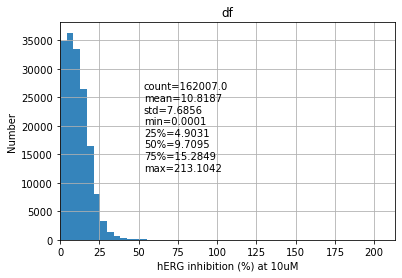

In [30]:
plot_pIC50(df, name='df', value ='hERG inhibition (%) at 10uM')

Возьмем логарифм от активности и посмотим график заново:

In [31]:
def calculate_pIC50(i):
    p = -np.log10(i/1000000000)
    return p

In [32]:
df["p_activity"] = df['hERG inhibition (%) at 10uM'].apply(calculate_pIC50)

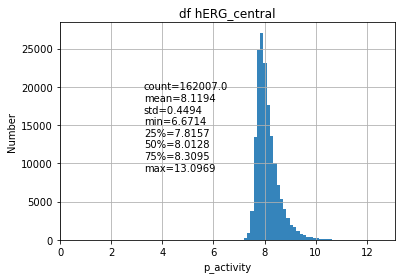

In [33]:
plot_pIC50(df, name='df hERG_central', value ='p_activity')

In [34]:
df["MW"] = [Chem.Descriptors.MolWt(Chem.MolFromSmiles(m)) for m in df["SMILES"]] 

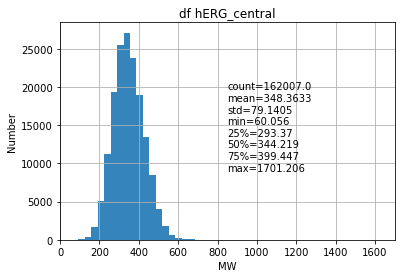

In [37]:
plot_pIC50(df, name='df hERG_central', value ='MW')

In [38]:
#df = df[df['MW'] > 150]

In [39]:
#df

In [91]:
def calc_morgan(mols):
    """ генерация молекулярных отпечатков по методу Моргана с радиусом 3
    """
    #t0 = time.time()
    for_df = []
    i=0
    for m in tqdm(mols):
        i+=1
        #t1 = time.time()
        #print("Processing compound {} ({}%)".format(i, 100*i//len(mols)), end="")
        arr = zeros((1,), dtype=int)
        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(m, 4, 512), arr)
        for_df.append(arr)
        #t2 = time.time()
        #print(" {}s (total: {}s)".format(t2-t1, t2-t0))
    return DataFrame(for_df)

In [92]:
fp_mg = calc_morgan(df["ROMol"])

100%|████████████████████████████████████████████████████████████████████████| 162007/162007 [00:27<00:00, 5869.33it/s]


In [94]:
len(fp_mg)

162007

In [99]:
fp_mg2_bin = [AllChem.GetMorganFingerprintAsBitVect(m, 4, nBits=512) for m in tqdm(df["ROMol"])]

100%|████████████████████████████████████████████████████████████████████████| 162007/162007 [00:24<00:00, 6595.78it/s]


In [101]:
len(fp_mg2_bin)

162007

Рассчитаем значения Танимото индексов каждого соединения с каждым. А далее запишем только максимальные попраные значения индексов Танимото.

In [111]:
def calculate_tanimoto_matrix_inside(fp_mg2_bin_test):
# Помимо работы calculate_tanimoto_matrix, данная функция также обнуляет значения по диагонали (они нам не интересны, это индекс Танимото соединения самого с собой, равен 1.0), а также расчитывает и выводит время расчетов (актуально для больших датасетов)
    #df = pd.DataFrame(index=range(1),columns=range(len(fp_mg2_bin_test)))
    #t0 = time.time()
    idxs = []
    reses = []
    for idx in tqdm(range(len(fp_mg2_bin_test))):
        #t1 = time.time()
        #print("Processing compound {} ({}%)".format(idx, 100*idx//len(fp_mg2_bin_test)), end="")
        tanimoto_mg2_bin = DataStructs.BulkTanimotoSimilarity(fp_mg2_bin_test[idx], [fp for i, fp in enumerate(fp_mg2_bin_test)])
        del tanimoto_mg2_bin[idx]
        res = np.max(tanimoto_mg2_bin)
        idx = np.argmax(tanimoto_mg2_bin)
        reses.append(res)
        idxs.append(idx)
        #df_length = len(df)
        #df.loc[df_length] = tanimoto_mg2_bin
        #t2 = time.time()
        #print(" {}s (total: {}s)".format(t2-t1, t2-t0))
    #df = df.iloc[1: , :]
    #df1 = df.where(df.values != np.diag(df),0,df.where(df.values != np.flipud(df).diagonal(0),0,inplace=True))
    return (reses, idxs)

In [112]:
reses, idxs = calculate_tanimoto_matrix_inside(fp_mg2_bin)

100%|████████████████████████████████████████████████████████████████████████| 162007/162007 [3:27:17<00:00, 13.03it/s]


In [117]:
df["Tan"] = reses

In [118]:
df["Tan_idxs"] = idxs

In [124]:
PandasTools.WriteSDF(df, 'herg_central_Tan_Matrix.sdf', molColName='ROMol', properties=list(df.columns))

In [126]:
del df["ROMol"]

In [127]:
df.to_csv("herg_central_Tan_matrix.csv", encoding='utf-8', index=False)

In [2]:
df = pd.read_table("herg_central_Tan_matrix.csv", sep = ",", engine='python')
df

,SMILES,PubChem Substance ID,hERG inhibition (%) at 1uM,hERG inhibition (%) at 10uM,class,Tan,Tan_idxs
0,CCOC(=O)N1CCC(CC1)NCCNC(=O)C2=CC=CC=C2Cl,842134,11.0704,8.65188,0,0.587500,987
1,CC1=CC2=C(C=C1)N=C(C(=C2)C#N)N3CCN(CC3)CC4=NN=...,842137,9.7533,3.52888,0,0.456140,26733
2,CC1(C(=O)N(C(=O)N1)CC(COC2CCCCC2)O)C,842138,6.0320,8.64368,0,0.508772,1504
3,C1CC1C2=CC=[N+](C=C2)[O-],842139,8.6582,7.12878,0,0.255319,25468
4,COC1=CC=C(C=C1)C(=O)NC2=NN=C(S2)C(F)(F)F,842140,58.0609,68.65378,1,0.573529,63460
...,...,...,...,...,...,...,...
162002,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@@H]2[C...,85149172,14.6462,23.14528,0,0.666667,47816
162003,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@H]2[C@...,85149177,10.6273,16.26908,0,0.453608,131046
162004,CC1(C=CC2=C(O1)C=CC3=C2OC[C@@H](C3)C4=C(C=C(C=...,85149178,11.5510,17.66578,0,1.000000,108671
162005,C1=CC(=CC=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O[C@...,85149179,14.0645,15.93398,0,0.723404,47816


In [4]:
def count_tanimoto_range_3(df1, dot1, dot2):
    # данная функция расчитывает диапазон по индексу Танимото, куда попали пары соедиений. Диапазон из 3 частей.
    count_ = Counter()
    for i in df1:
        if i <= dot1:
            count_[f"Tanimoto_index = 0.00 - {dot1}"]+=1
        elif i <= dot2 and i > dot1:
            count_[f"Tanimoto_index = {dot1} - {dot2}"]+=1
        elif i >  dot2:
            count_[f"Tanimoto_index = {dot2} - 1.00"]+=1
    return count_

Посмотрим как много пар сильно похожих соединений:

In [5]:
count = count_tanimoto_range_3(df["Tan"], 0.33, 0.66)
print(count)

Counter({'Tanimoto_index = 0.33 - 0.66': 91069, 'Tanimoto_index = 0.66 - 1.00': 68949, 'Tanimoto_index = 0.00 - 0.33': 1989})


Выборка hERG_central интересная, большинство пар соединений лежат посередине (т.е. меньше похожи друг на друга, чем в случае с выборкой ChEMBL)

In [138]:
df[df['Tan'] == 1.0]

,SMILES,PubChem Substance ID,hERG inhibition (%) at 1uM,hERG inhibition (%) at 10uM,class,Tan,Tan_idxs,ROMol
493,COC(=O)CCCCC1C(C(CS1)NC(=O)OC)NC(=O)OC,843570,10.9055,2.08618,0,1.0,29227,"<img data-content=""rdkit/molecule"" src=""data:i..."
1099,CCOC(=O)C1=CN=CN1C(C)C2=CC=CC=C2,845401,11.8830,13.31818,0,1.0,131085,"<img data-content=""rdkit/molecule"" src=""data:i..."
1497,CN\1C2=CC=CC=C2S/C1=C/C(=O)C3=CC=CS3,846550,13.8331,14.77008,0,1.0,34761,"<img data-content=""rdkit/molecule"" src=""data:i..."
3957,C[C@]12CCC(=O)C=C1CC[C@@H]3[C@@H]2CC[C@]4([C@H...,855521,13.1740,9.16938,0,1.0,131063,"<img data-content=""rdkit/molecule"" src=""data:i..."
3975,CC(C)(C)NCC(COC1=CC=CC2=C1C[C@@H]([C@@H](C2)O)O)O,855594,19.2214,28.97688,0,1.0,156789,"<img data-content=""rdkit/molecule"" src=""data:i..."
...,...,...,...,...,...,...,...,...
161991,CC1([C@H]([C@@H](C2=C(O1)C=CC3=C2OC(=O)C=C3)O)O)C,85149146,16.3307,25.71588,0,1.0,161991,"<img data-content=""rdkit/molecule"" src=""data:i..."
161992,CC1([C@@H]([C@H](C2=C(O1)C=CC3=C2OC(=O)C=C3)O)O)C,85149147,13.1848,21.74538,0,1.0,161991,"<img data-content=""rdkit/molecule"" src=""data:i..."
161993,CC1([C@@H]([C@@H](C2=C(O1)C=CC3=C2OC(=O)C=C3)O...,85149148,10.3472,15.45308,0,1.0,161991,"<img data-content=""rdkit/molecule"" src=""data:i..."
162000,C[C@H]1[C@H](CC2C1[C@@H](OC=C2C(=O)OC)O[C@H]3[...,85149169,12.1695,17.84698,0,1.0,108786,"<img data-content=""rdkit/molecule"" src=""data:i..."


Всего 1316 стереоизомеров. На самом деле, возможно, действительно проблема на этапе конвертации в объект mol (молекулы). Но чтобы это исправить придется писать большой скрипт(

In [136]:
def plot_pIC50_sort(df1_sort, name):
    # функция для построения распределения по значению индекса Танимото для пар соединений тест-трэйн
    c,me,std,mi,procent1, procent2, procent3, ma = df1_sort.describe().round(4)
    n, bins, patches = plt.hist(df1_sort, 50)

    plt.xlabel('Tanimoto_index')
    plt.ylabel('Number of pairs')
    plt.title(f'{name}')
    plt.xlim(0, 1)
    plt.annotate(f'count={c}\nmean={me}\nstd={std}\nmin={mi}\n25%={procent1}\n50%={procent2}\n75%={procent3}\nmax={ma}', xy=(0.2, np.max(n)/3))
    # plt.ylim(0, 1)
    plt.grid(True)
    plt.show()
    

Посмотрим гистограмму распределения по наибольшим попарным значениям индекса Танимото.

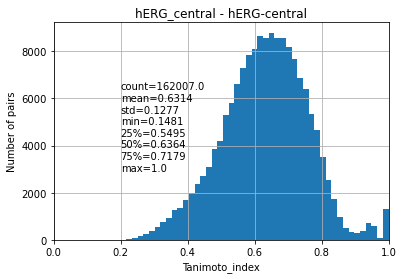

In [137]:
plot_pIC50_sort(df["Tan"], name='hERG_central - hERG-central')

Загрузим датасет ChEMBL

,canonical_smiles,molecule_chembl_id,molecule_pref_name,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50,ID,ROMol
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccccc3)c3ccc(Cl)cc23)CC1,CHEMBL443476,nan,=,IC50,nM,nM,88.0,422.96,88.0,1,7.055517,,
1,O=C1NCCN1CCN1CCC(c2cn(C3CCCCC3)c3ccc(Cl)cc23)CC1,CHEMBL53661,nan,=,IC50,nM,nM,137.0,429.008,137.0,1,6.863279,,
2,CCC(CC)c1cn(-c2ccc(F)cc2)c2ccc(Cl)cc12,CHEMBL299390,nan,=,IC50,nM,nM,1480.0,315.819,1480.0,1,5.829738,,
3,O=C1NCCN1CCN1CC=C(c2cn(-c3ccc(F)cc3)c3ccc(Cl)c...,CHEMBL12186,nan,=,IC50,nM,nM,10.0,438.934,10.0,1,8.0,,
4,CC(C)(C)c1ccc2c(ccn2-c2ccc(F)cc2)c1,CHEMBL299590,nan,>,IC50,nM,nM,10000.0,267.347,10000.0,0,5.0,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(...,CHEMBL4635883,nan,=,IC50,nM,uM,3.7,397.527,3700.0,1,5.431798,,
7437,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C...,CHEMBL4643105,nan,=,IC50,nM,nM,2007.0,464.516,2007.0,1,5.697453,,
7438,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2...,CHEMBL4634921,nan,=,IC50,nM,nM,1607.0,482.506,1607.0,1,5.793984,,
7439,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC...,CHEMBL4634696,nan,=,IC50,nM,nM,3352.0,468.479,3352.0,1,5.474696,,

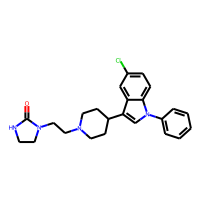
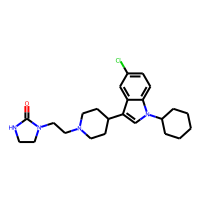
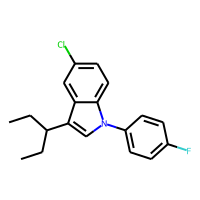
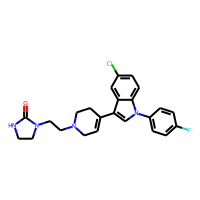
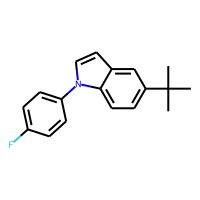
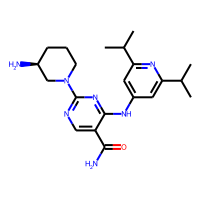
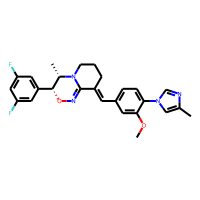
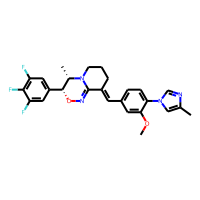
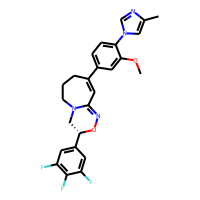
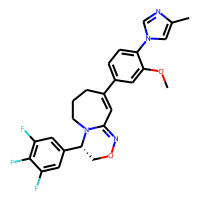

In [23]:
df_1 = PandasTools.LoadSDF('herg_smaller_right.sdf',molColName='ROMol')
df_1

In [26]:
df_1 = df_1.rename(columns={"molecule_chembl_id": "molecule_id"})

In [27]:
df_1 = df_1[['canonical_smiles', "molecule_id", 'class', "ROMol"]]

In [29]:
df = df.rename(columns={"SMILES": 'canonical_smiles'})

In [32]:
df = df.rename(columns={"PubChem Substance ID": 'molecule_id'})

In [33]:
df = df[['canonical_smiles', "molecule_id", 'class', "ROMol"]]

In [35]:
df_united = df.append(df_1, sort=False)

C:\Users\elly-\AppData\Local\Temp/ipykernel_6416/1478375770.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_united = df.append(df_1, sort=False)


In [37]:
df_united.reset_index(drop=True, inplace=True)

Сохраним объединенный датасет

In [38]:
PandasTools.WriteSDF(df_united, 'df_united.sdf', molColName='ROMol', properties=list(df_united.columns))

In [39]:
df_united.to_csv("df_united.csv", encoding='utf-8', index=False)

Вывод:
    В резултате мы получили объединенный датасет. 